# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

___

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

___

In [2]:
azdias = pd.read_csv('data/Udacity_AZDIAS_Subset.csv',encoding='utf-8',sep=';')

feat_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv',encoding='utf-8',sep=';')

In [3]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

___

In [5]:
na_dict = {}

for column in list(azdias.columns):
    codes_array = feat_info[feat_info['attribute'] == column]['missing_or_unknown'].values
    codes = str(codes_array).replace("[","").replace("]","").replace("'","").split(',')
    nan_codes = []
    for code in codes:
        if code not in ('','X','XX'):
            nan_codes.append(int(code))
        else:
            nan_codes.append(code)
    na_dict[column] = nan_codes

na_dict

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-

In [6]:
azdias_df = pd.read_csv('data/Udacity_AZDIAS_Subset.csv', encoding='utf-8', sep=';',
                        na_values=na_dict)

azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             780025 non-nu

In [7]:
azdias_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
comp_nans = pd.concat([azdias_df.isna().sum(), azdias.isna().sum()], axis=1)
comp_nans.columns = ['coded_nans','really_missin']
comp_nans['diff'] = comp_nans['coded_nans']-comp_nans['really_missin']
comp_nans

,coded_nans,really_missin,diff
AGER_TYP,685843,0,685843
ALTERSKATEGORIE_GROB,2881,0,2881
ANREDE_KZ,0,0,0
CJT_GESAMTTYP,4854,4854,0
FINANZ_MINIMALIST,0,0,0
...,...,...,...
PLZ8_HHZ,116515,116515,0
PLZ8_GBZ,116515,116515,0
ARBEIT,97375,97216,159
ORTSGR_KLS9,97274,97216,58


In [9]:
print(f"The dataset with unknown data has: {azdias.isna().sum().sum()} NaNs\nAnd the dataset after converting those in NaNs has: {azdias_df.isna().sum().sum()}")

The dataset with unknown data has: 4896838 NaNs
And the dataset after converting those in NaNs has: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

___

In [10]:
comp_nans['pctg_coded_nans'] = comp_nans['coded_nans'] / azdias_df.shape[0] * 100
comp_nans['pctg_real_nans'] = comp_nans['really_missin'] / azdias.shape[0] * 100
comp_nans.sort_values(by=['pctg_coded_nans'],ascending=False).head()

,coded_nans,really_missin,diff,pctg_coded_nans,pctg_real_nans
TITEL_KZ,889061,73499,815562,99.757636,8.247000
AGER_TYP,685843,0,685843,76.955435,0.000000
KK_KUNDENTYP,584612,584612,0,65.596749,65.596749
KBA05_BAUMAX,476524,133324,343200,53.468668,14.959701
GEBURTSJAHR,392318,0,392318,44.020282,0.000000


<AxesSubplot:>

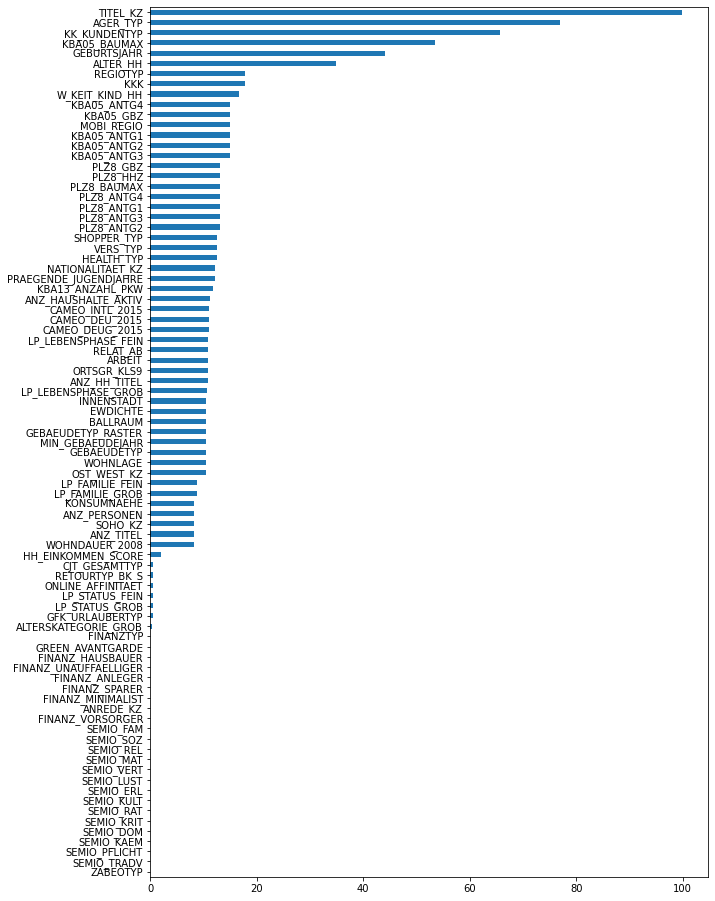

In [11]:
plt.figure(figsize=[10, 16])
comp_nans.sort_values(by=['pctg_coded_nans'],ascending=True)['pctg_coded_nans'].plot(kind='barh')

In [12]:
cols_to_drop = list(comp_nans[comp_nans['pctg_coded_nans'] >= 20].index)
cols_to_drop

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [13]:
reduced_df = azdias_df.drop(columns=cols_to_drop)
reduced_df.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

> I decided to drop those 9 columns given the high percentage of NaN values after replacing the missing/unknown codes for np.nan

> The criteria, drop every column with > than 15% of NaNs

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

___

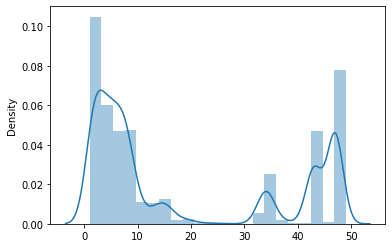

In [14]:
nans_per_row = reduced_df.isnull().sum(axis=1)
sns.distplot(nans_per_row[nans_per_row.values > 0], bins=22)
plt.show()

In [15]:
reduced_df.iloc[nans_per_row[nans_per_row.values > 30].sample(6).index, -23:]

,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
637255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
reduced_df.iloc[nans_per_row[nans_per_row.values < 20].sample(6).index, :]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
696748,1.0,1,5.0,4,4,2,5,5,3,4,...,2.0,3.0,1.0,0.0,1.0,4.0,4.0,4.0,6.0,3.0
204729,3.0,2,4.0,5,1,5,1,1,2,5,...,4.0,1.0,0.0,0.0,1.0,3.0,4.0,4.0,7.0,5.0
852781,4.0,2,2.0,2,1,5,1,1,5,6,...,2.0,3.0,3.0,1.0,3.0,3.0,3.0,4.0,9.0,3.0
855456,1.0,1,3.0,2,5,1,4,3,4,6,...,1.0,1.0,2.0,2.0,5.0,5.0,2.0,4.0,9.0,3.0
579058,2.0,2,3.0,3,4,1,4,3,3,6,...,2.0,2.0,1.0,0.0,1.0,5.0,5.0,4.0,9.0,3.0
565373,3.0,1,3.0,2,4,1,3,3,4,6,...,1.0,3.0,3.0,2.0,5.0,3.0,1.0,4.0,8.0,4.0


In [17]:
reduced_df_A = reduced_df.iloc[nans_per_row[nans_per_row.values < 20].index, :]
reduced_df_B = reduced_df.iloc[nans_per_row[nans_per_row.values >= 20].index, :]

print(f'The dataset for the group with few or no missing values `reduced_df_A` has a shape {reduced_df_A.shape}')
print(f'The dataset for the group with many missing values `reduced_df_B` has a shape {reduced_df_B.shape}')

The dataset for the group with few or no missing values `reduced_df_A` has a shape (797077, 79)
The dataset for the group with many missing values `reduced_df_B` has a shape (94144, 79)


#### Discussion 1.1.3: Assess Missing Data in Each Row

> The distribution shows 2 groups of rows/registers those having less than 20 features with NaN values and those with 30 or more features with NaN values

> For the group with > 30, they have missing the features related to 

> - Community-level
> - PLZ8 macro-cell
> - RR1 region
> - Postcode-level
> - RR3 micro-cell
> - RR4 micro-cell
> - Building-level
> - Household-level features

> In other words, those just have PERSONAL LEVEL features

> So I'll split the reduced dataset we have so far into these 2 groups

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

___

In [18]:
mixed_features = list(feat_info.query('type == "mixed"').attribute)
mixed_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [19]:
categorical_features = list(feat_info.query('type == "categorical"').attribute)
categorical_features

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [20]:
for col in mixed_features:
    if col in reduced_df_A.columns:
        print(col)
        print(reduced_df_A[col].unique())

LP_LEBENSPHASE_FEIN
[21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13. 18.
 31. 38. 35. 30.  7. 22. 14. 29. 24. 28. 37. 26. 39. 27. 36.  9. 34. 33.
 15. 40. 16. 19. 17.]
LP_LEBENSPHASE_GROB
[ 6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  4.  8.]
PRAEGENDE_JUGENDJAHRE
[14. 15.  8.  3. 10. 11.  5.  9.  6.  4. nan  2.  1. 12. 13.  7.]
WOHNLAGE
[4. 2. 7. 3. 5. 1. 8. 0.]
CAMEO_INTL_2015
[51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. nan 25. 23. 31. 52.
 35. 45. 44. 32.]
PLZ8_BAUMAX
[ 1.  2. nan  4.  5.  3.]


In [21]:
for col in categorical_features:
    if col in reduced_df_A.columns:
        print(col)
        print(reduced_df_A[col].unique())

ANREDE_KZ
[2 1]
CJT_GESAMTTYP
[ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP
[1 6 5 2 4 3]
GFK_URLAUBERTYP
[10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
GREEN_AVANTGARDE
[0 1]
LP_FAMILIE_FEIN
[ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB
[ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN
[ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB
[ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ
[ 1.  3.  2. nan]
SHOPPER_TYP
[ 3.  2.  1.  0. nan]
SOHO_KZ
[1. 0.]
VERS_TYP
[ 2.  1. nan]
ZABEOTYP
[5 3 4 1 6 2]
GEBAEUDETYP
[8. 1. 3. 2. 6. 4. 5.]
OST_WEST_KZ
['W' 'O']
CAMEO_DEUG_2015
[ 8.  4.  2.  6.  1.  9.  5.  7. nan  3.]
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

____

#### Discussion 1.2.1: Re-Encode Categorical Features

> **CATEGORICALS**

> - ANREDE_KZ: I'll make that binary (male/female)
> - CJT_GESAMTTYP: I'll keep these one
> - FINANZTYP: I'll keep these one but drop all those sub branches FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER
> - GFK_URLAUBERTYP: I'll keep these one
> - LP_FAMILIE_FEIN and LP_FAMILIE_GROB: I'll just keep GROB (gross)
> - LP_STATUS_FEIN and LP_STATUS_GROB: I'll just keep GROB (gross)
> - NATIONALITAET_KZ: I'll keep these one
> - SHOPPER_TYP: I'll keep these one
> - SOHO_KZ and GREEN_AVANTGARDE: Those already are binary
> - VERS_TYP: I'll keep these one
> - ZABEOTYP: I'll keep these one
> - GEBAEUDETYP: I'll keep these one
> - OST/WST: I'll make that binary (east/west)
> - CAMEO DEUG and CAMEO DEU: I'll just keep DEUG (rough scale)

> *NOTE:* for all those that I decided to keep, those will be ONE HOT ENCODED

In [22]:
reduced_df_A['ANREDE_KZ'].replace({1:0, 2:1}, inplace=True)
reduced_df_A['OST_WEST_KZ'].replace({'O':0, 'W':1}, inplace=True)
#one_hot_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

___

#### Discussion 1.2.2: Engineer Mixed-Type Features

> **MIXED**

> - LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB: I'll drop those since STATUS GROB already has that information
> - PRAEGENDE_JUGENDJAHRE: I'll perform the suggested engineering
> - WOHNLAGE: I'll drop this one
> - CAMEO_INTL_2015: I'll perform the suggested engineering
> - PLZ8_BAUMAX: I'll drop this one

In [23]:
praegende_dict = { 1: 0, 2: 0, 3: 1, 4: 1, 5: 2,
                6: 2, 7:2 , 8:3, 9: 3, 10: 4,
                11: 4, 12: 4, 13: 4, 14: 5, 15: 5, 999: np.nan}

reduced_df_A['PRAEGENDE_JUGENDJAHRE'] = reduced_df_A['PRAEGENDE_JUGENDJAHRE'].replace(np.nan,999).astype(int).replace(praegende_dict)
list(reduced_df_A['PRAEGENDE_JUGENDJAHRE'].unique())

[5.0, 3.0, 1.0, 4.0, 2.0, nan, 0.0]

In [24]:
reduced_df_A['CAMEO_INTL_2015_W'] = reduced_df_A['CAMEO_INTL_2015'].astype(str).str[0]
reduced_df_A['CAMEO_INTL_2015_L'] = reduced_df_A['CAMEO_INTL_2015'].astype(str).str[1]
reduced_df_A[['CAMEO_INTL_2015','CAMEO_INTL_2015_W','CAMEO_INTL_2015_L']].sample(20)

,CAMEO_INTL_2015,CAMEO_INTL_2015_W,CAMEO_INTL_2015_L
888150,43.0,4,3
241001,34.0,3,4
880056,22.0,2,2
842095,41.0,4,1
702935,51.0,5,1
720092,55.0,5,5
499944,14.0,1,4
648508,25.0,2,5
348663,25.0,2,5
543951,24.0,2,4


In [25]:
columns_to_drop = ['LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','CAMEO_INTL_2015','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','CAMEO_DEU_2015']
reduced_df_A.drop(columns=columns_to_drop, inplace=True)

In [26]:
# after spliting we get 'n' and 'a' values
for col in ['CAMEO_INTL_2015_W','CAMEO_INTL_2015_L']:
    print(reduced_df_A[col].unique())

['5' '2' '1' '4' '3' 'n']
['1' '4' '2' '3' '5' 'a']


In [27]:
reduced_df_A['CAMEO_INTL_2015_W'] = pd.to_numeric(reduced_df_A['CAMEO_INTL_2015_W'].replace('n',np.nan), errors='coerce')
reduced_df_A['CAMEO_INTL_2015_L'] = pd.to_numeric(reduced_df_A['CAMEO_INTL_2015_L'].replace('a',np.nan), errors='coerce')
    
reduced_df_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 67 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   794304 non-null  float64
 1   ANREDE_KZ              797077 non-null  int64  
 2   CJT_GESAMTTYP          792445 non-null  float64
 3   FINANZTYP              797077 non-null  int64  
 4   GFK_URLAUBERTYP        792445 non-null  float64
 5   GREEN_AVANTGARDE       797077 non-null  int64  
 6   HEALTH_TYP             760739 non-null  float64
 7   LP_FAMILIE_GROB        766095 non-null  float64
 8   LP_STATUS_GROB         792445 non-null  float64
 9   NATIONALITAET_KZ       763512 non-null  float64
 10  PRAEGENDE_JUGENDJAHRE  768753 non-null  float64
 11  RETOURTYP_BK_S         792445 non-null  float64
 12  SEMIO_SOZ              797077 non-null  int64  
 13  SEMIO_FAM              797077 non-null  int64  
 14  SEMIO_REL              797077 non-nu

In [28]:
reduced_df_A = pd.get_dummies(reduced_df_A, dummy_na=True)
reduced_df_A.shape

(797077, 67)

In [29]:
reduced_df_A.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_FAMILIE_GROB',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_AN

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

___

In [30]:
reduced_df_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 67 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   794304 non-null  float64
 1   ANREDE_KZ              797077 non-null  int64  
 2   CJT_GESAMTTYP          792445 non-null  float64
 3   FINANZTYP              797077 non-null  int64  
 4   GFK_URLAUBERTYP        792445 non-null  float64
 5   GREEN_AVANTGARDE       797077 non-null  int64  
 6   HEALTH_TYP             760739 non-null  float64
 7   LP_FAMILIE_GROB        766095 non-null  float64
 8   LP_STATUS_GROB         792445 non-null  float64
 9   NATIONALITAET_KZ       763512 non-null  float64
 10  PRAEGENDE_JUGENDJAHRE  768753 non-null  float64
 11  RETOURTYP_BK_S         792445 non-null  float64
 12  SEMIO_SOZ              797077 non-null  int64  
 13  SEMIO_FAM              797077 non-null  int64  
 14  SEMIO_REL              797077 non-nu

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

___

In [31]:
def clean_data(csv_path):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = pd.read_csv(csv_path, encoding='utf-8', sep=';', na_values=na_dict)                # read CSV and convert unknown codes to np.nan

    cols_to_drop = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    for col in cols_to_drop:
        if col in list(df.columns):
            df.drop(columns=col, inplace=True)                                 
    df = df.loc[df.isna().sum(axis=1).values < 20, :]                                       # drop those rows with 20 or more features empty
    
    if 'ANREDE_KZ' in list(df.columns):
        df['ANREDE_KZ'].replace({1:0, 2:1}, inplace=True)                               # encode binary var
    if 'OST_WEST_KZ' in list(df.columns):
        df['OST_WEST_KZ'].replace({'O':0, 'W':1}, inplace=True)                         # encode binary var
    
    praegende_dict = { 1: 0, 2: 0, 3: 1, 4: 1, 5: 2, 6: 2, 7:2 , 8:3,                       # rengineer praegende jugendjahre
                9: 3, 10: 4, 11: 4, 12: 4, 13: 4, 14: 5, 15: 5, 999: np.nan}
    if 'PRAEGENDE_JUGENDJAHRE' in list(df.columns):
        df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].replace(np.nan,999).astype(int).replace(praegende_dict)
    
    if 'CAMEO_INTL_2015' in list(df.columns):
        df['CAMEO_INTL_2015_W'] = df['CAMEO_INTL_2015'].astype(str).str[0]      # rengineer CAMEO INTL
        df['CAMEO_INTL_2015_L'] = df['CAMEO_INTL_2015'].astype(str).str[1]
        df['CAMEO_INTL_2015_W'] = pd.to_numeric(df['CAMEO_INTL_2015_W'].replace('n',np.nan), errors='coerce')
        df['CAMEO_INTL_2015_L'] = pd.to_numeric(df['CAMEO_INTL_2015_L'].replace('a',np.nan), errors='coerce')
    
    cols_to_drop = ['LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','CAMEO_INTL_2015',
                'FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','CAMEO_DEU_2015']
    for col in cols_to_drop:
        if col in list(df.columns):
            df.drop(columns=col, inplace=True)

    # Return the cleaned dataframe.
    return df

In [32]:
# does this function achieve the same result we have so far?
reduced_df_A.equals(clean_data('data/Udacity_AZDIAS_Subset.csv'))

True

In [33]:
# one more check
assert reduced_df_A.shape[0] == clean_data('data/Udacity_AZDIAS_Subset.csv').shape[0], "clean_data function is not working properly, rows mismatch"
assert reduced_df_A.shape[1] == clean_data('data/Udacity_AZDIAS_Subset.csv').shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


___

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

___

In [34]:
# If you've not yet cleaned the dataset of all NaN values, do that now.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent') # given the kind of vars we have
nan_free_df = pd.DataFrame(imputer.fit_transform(reduced_df_A))
nan_free_df.columns = reduced_df_A.columns

nan_free_df.isna().sum().sum()

0

In [35]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

std_scaled_df = pd.DataFrame(std_scaler.fit_transform(nan_free_df))
std_scaled_df.columns = reduced_df_A.columns

mm_scaled_df = pd.DataFrame(mm_scaler.fit_transform(nan_free_df))
mm_scaled_df.columns = reduced_df_A.columns

### Discussion 2.1: Apply Feature Scaling

> Decided to impute the *mode* because we are dealing with ordinal values and *mean* or *median* would not be the best for this case

> Decided to try both Standard and MinMax scalers and compare results with both assuming minmax will perform better in this case

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

___

In [36]:
# Apply PCA to the data.
# Investigate the variance accounted for by each principal component.
from sklearn.decomposition import PCA

std_pca = PCA()
std_pca.fit(std_scaled_df)
std_pca.explained_variance_ratio_[:20]

array([0.16352039, 0.11123326, 0.08080219, 0.04586123, 0.03703834,
       0.03133049, 0.03026885, 0.02536659, 0.02349552, 0.02098865,
       0.02014635, 0.01833618, 0.01802203, 0.01708818, 0.01604479,
       0.01515013, 0.01491548, 0.01431757, 0.01402214, 0.01348661])

In [37]:
mm_pca = PCA()
mm_pca.fit(mm_scaled_df)
mm_pca.explained_variance_ratio_[:20]

array([0.16518268, 0.12504065, 0.09252288, 0.05165941, 0.04430873,
       0.03694243, 0.03101371, 0.0265046 , 0.02459962, 0.0225992 ,
       0.02203785, 0.0199692 , 0.01850414, 0.01696707, 0.01583649,
       0.01547105, 0.01527332, 0.0147751 , 0.0141002 , 0.0134065 ])

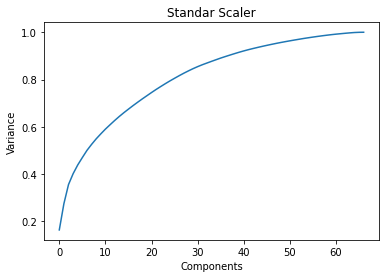

In [38]:
plt.plot(np.cumsum(std_pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Variance')
plt.title('Standar Scaler')
plt.show()

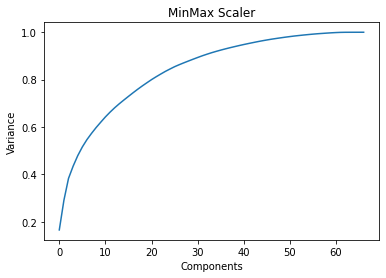

In [39]:
plt.plot(np.cumsum(mm_pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Variance')
plt.title('MinMax Scaler')
plt.show()

In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.
mm_pca_20 = PCA(n_components=20)
mm_pca_20.fit(mm_scaled_df)

PCA(n_components=20)

### Discussion 2.2: Perform Dimensionality Reduction

> MinMax Scaler seems to do a better job because the variance explained is higher for a smaller number of components

> Finally decided to use 20 components for aprox 80% variance explanation

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

___

In [41]:
# Map weights for the 1st, 2nd and 3rd principal components to corresponding feature names
# HINT: Try defining a function that you can reuse

def map_weights_pca(comp, pca_obj):
    weights_df = pd.DataFrame(pca_obj.components_, columns=pca_obj.feature_names_in_)
    df_head = weights_df.loc[comp].sort_values().head() # most positively weighted
    df_tail = weights_df.loc[comp].sort_values().tail() # most negatively weighted
    return df_head.append(df_tail)

<AxesSubplot:>

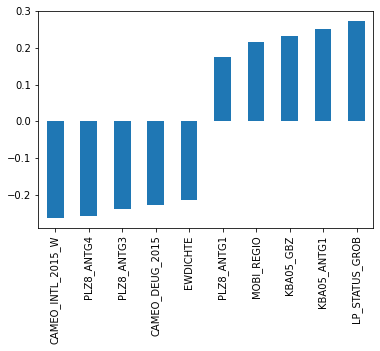

In [42]:
# 1st COMPONENT
map_weights_pca(0,mm_pca_20).plot.bar()

<AxesSubplot:>

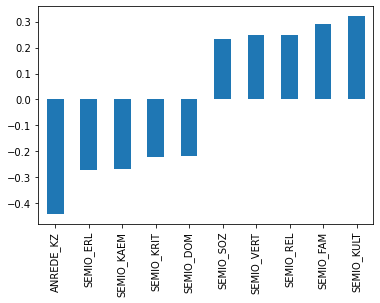

In [43]:
# 2nd COMPONENT
map_weights_pca(1,mm_pca_20).plot.bar()

<AxesSubplot:>

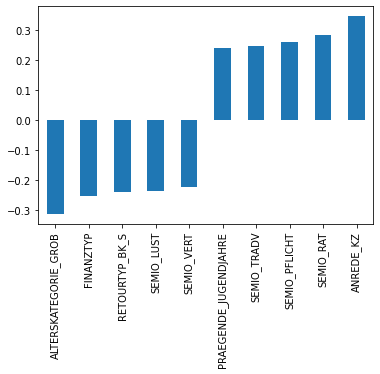

In [44]:
# 3rd COMPONENT
map_weights_pca(2,mm_pca_20).plot.bar()

### Discussion 2.3: Interpret Principal Components

> **1st COMPONENT:** weighted towards wealth and number of family houses/households density

> **2nd COMPONENT:** weighted towards gender and personality type

> **3rd COMPONENT:** weighted towards age, and personality, shopper, return types

___

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 

**Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.

- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. 

**Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.

- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

___

In [45]:
# Over a number of different cluster counts...
# run k-means clustering on the data and compute the average within-cluster distances.
from sklearn.cluster import KMeans, MiniBatchKMeans

def elbow_method(data, n=20):
    dist = []
    for k in range(2, n):
        kmeans = MiniBatchKMeans(n_clusters=k, init='random')
        kmeans.fit(data)
        dist.append(kmeans.inertia_)

    #print(dist)
    fig = plt.figure(figsize=(12, 8))
    plt.plot(range(2, n), dist)
    plt.grid(True)
    plt.title('Elbow Method Graph')
    plt.show()

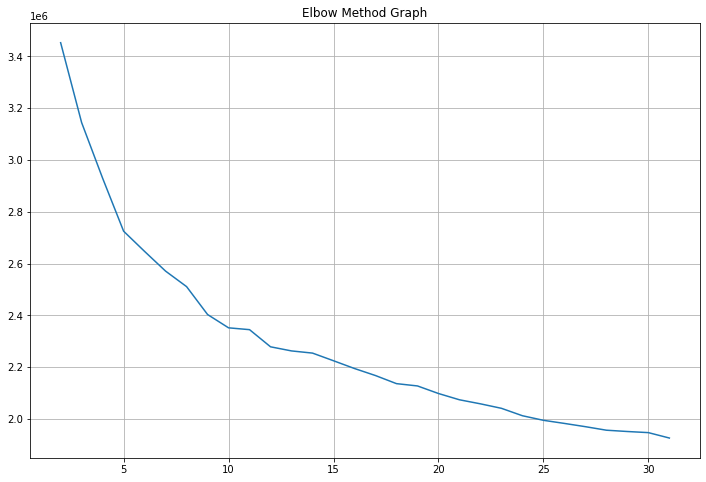

In [46]:
elbow_method(mm_pca_20.fit_transform(mm_scaled_df), 32)

> For elbow curve method I decided to use Mini Batch KMeans in order to reduce the computation time

> Now that I've decided the optimal k number of clusters I'll go on with standar KMeans

In [49]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

pca_df = mm_pca_20.fit_transform(mm_scaled_df)
kmeans = KMeans(n_clusters=21, init='random').fit(pca_df)
labels = kmeans.predict(pca_df)

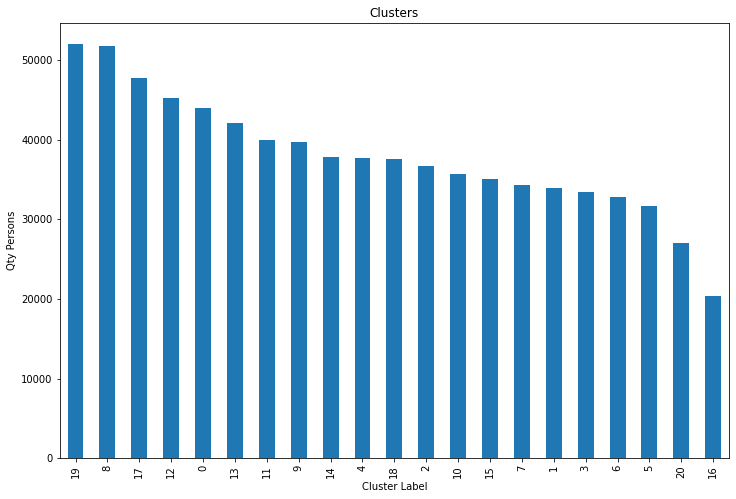

In [50]:
fig = plt.figure(figsize=(12, 8))
l=pd.Series(labels).value_counts()
l.plot.bar(x=l.values,y=l.index)
plt.title('Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Qty Persons')
plt.show()

### Discussion 3.1: Apply Clustering to General Population

> After plotting the intertia value for different number of clusters, elbow point seems to be between 20 and 22 clusters

> I choose to predict on data after training for 21 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

___

In [51]:
# Load in the customer demographics data.
# Apply preprocessing, feature transformation

customers = clean_data('data/Udacity_CUSTOMERS_Subset.csv')
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141590 entries, 0 to 191651
Data columns (total 67 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   141359 non-null  float64
 1   ANREDE_KZ              141590 non-null  int64  
 2   CJT_GESAMTTYP          138491 non-null  float64
 3   FINANZTYP              141590 non-null  int64  
 4   GFK_URLAUBERTYP        138491 non-null  float64
 5   GREEN_AVANTGARDE       141590 non-null  int64  
 6   HEALTH_TYP             139282 non-null  float64
 7   LP_FAMILIE_GROB        132292 non-null  float64
 8   LP_STATUS_GROB         138491 non-null  float64
 9   NATIONALITAET_KZ       139513 non-null  float64
 10  PRAEGENDE_JUGENDJAHRE  140324 non-null  float64
 11  RETOURTYP_BK_S         138491 non-null  float64
 12  SEMIO_SOZ              141590 non-null  int64  
 13  SEMIO_FAM              141590 non-null  int64  
 14  SEMIO_REL              141590 non-nu

In [53]:
# impute, scale and pca

nan_free_df = pd.DataFrame(imputer.transform(customers))
nan_free_df.columns = customers.columns

scaled_df = pd.DataFrame(mm_scaler.transform(nan_free_df))
scaled_df.columns = customers.columns

pca_df = mm_pca_20.transform(scaled_df)

customer_labels = kmeans.predict(pca_df)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

___

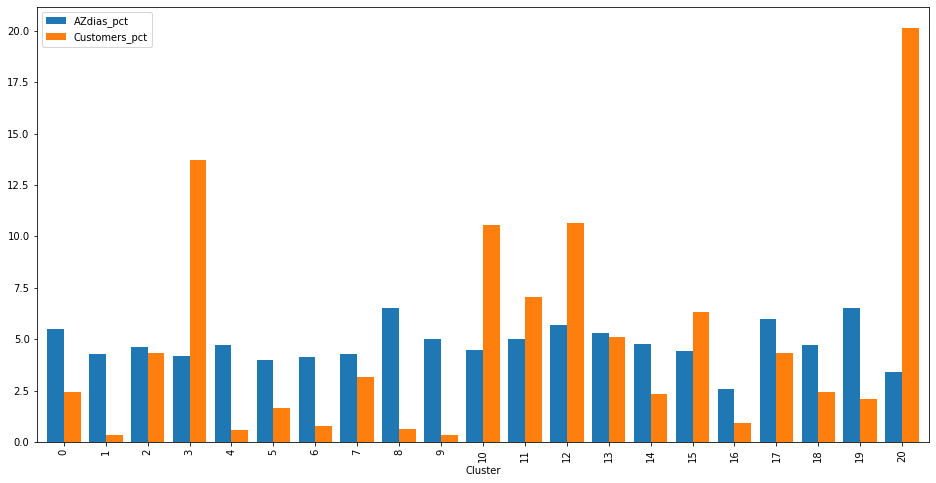

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
proportions = pd.DataFrame({
            'Cluster': range(0,21),
            'AZdias_sum': pd.Series(labels).value_counts().sort_index(),
            'Customers_sum': pd.Series(customer_labels).value_counts().sort_index()
            })

proportions['AZdias_pct']=proportions['AZdias_sum']*100/len(labels)
proportions['Customers_pct']=proportions['Customers_sum']*100/len(customer_labels)

proportions.plot(kind='bar',figsize=(16, 8), width=0.8, x='Cluster', y=['AZdias_pct', 'Customers_pct'])
plt.show()

In [55]:
# What kinds of people are part of a cluster that is overrepresented in the customer data?
# What kinds of people are part of a cluster that is underrepresented in the customer data?
overrep_cluster = customers.loc[list(pd.Series(customer_labels)==20)]
underrep_cluster = customers.loc[list(pd.Series(customer_labels)==9)]
print(f'OVERREPRESENTED: {overrep_cluster.shape} UNDERREPRESENTED: {underrep_cluster.shape}')

OVERREPRESENTED: (28509, 67) UNDERREPRESENTED: (510, 67)


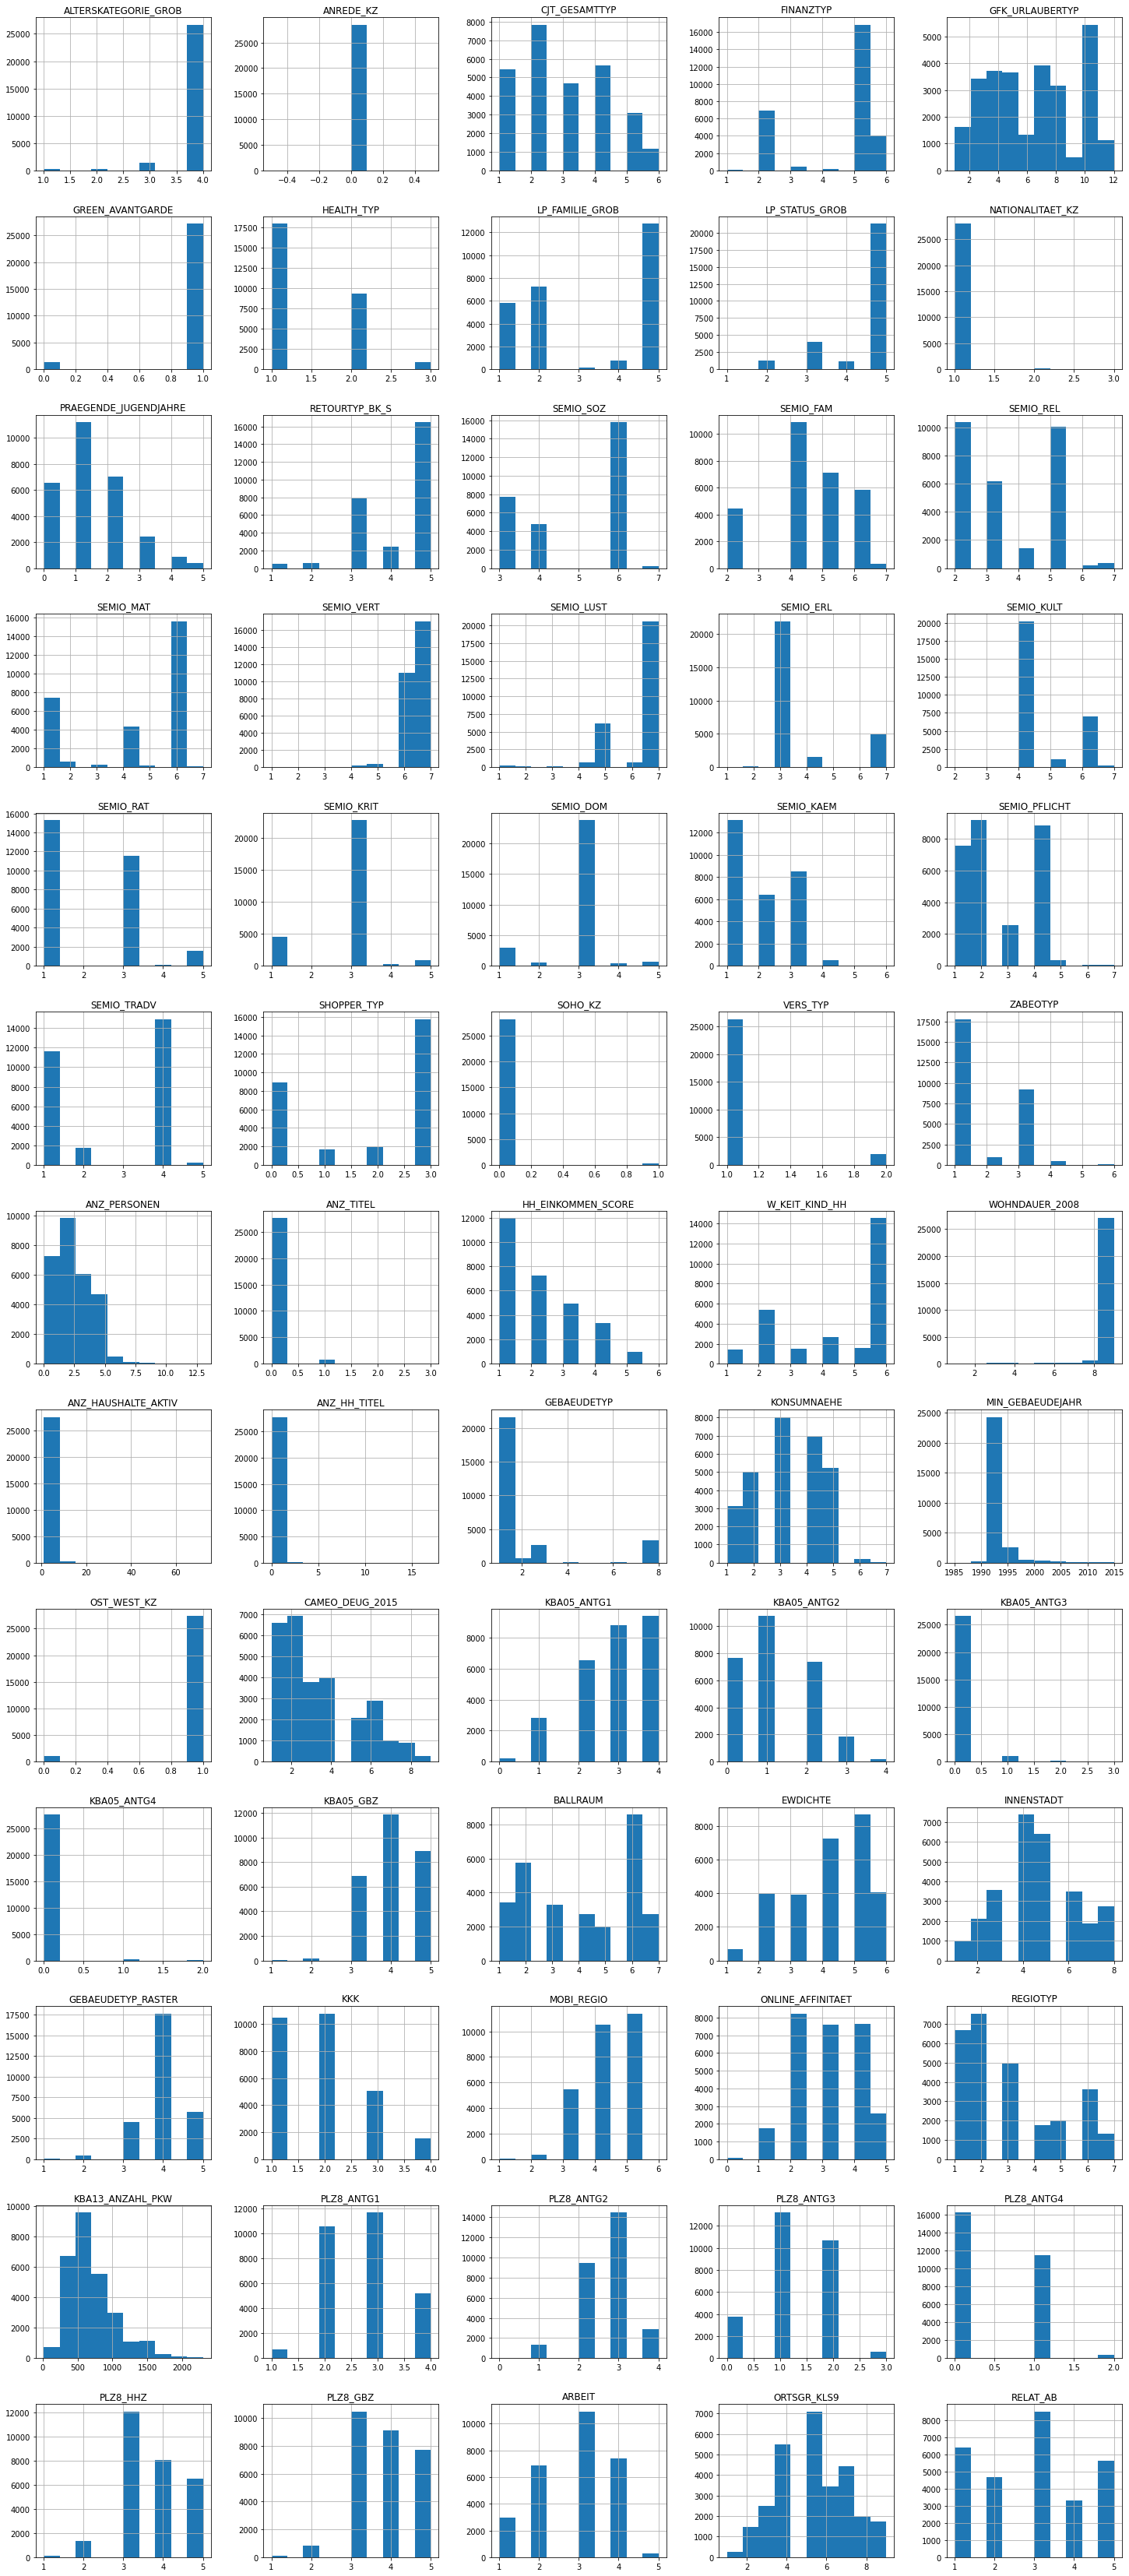

In [56]:
# OVER REPRESENTED
fig, axes = plt.subplots(len(overrep_cluster.columns)//5, 5, figsize=(25, 60))
i = 0
for triaxis in axes:
    for axis in triaxis:
        overrep_cluster.hist(column = overrep_cluster.columns[i], bins = 10, ax=axis)
        i = i+1

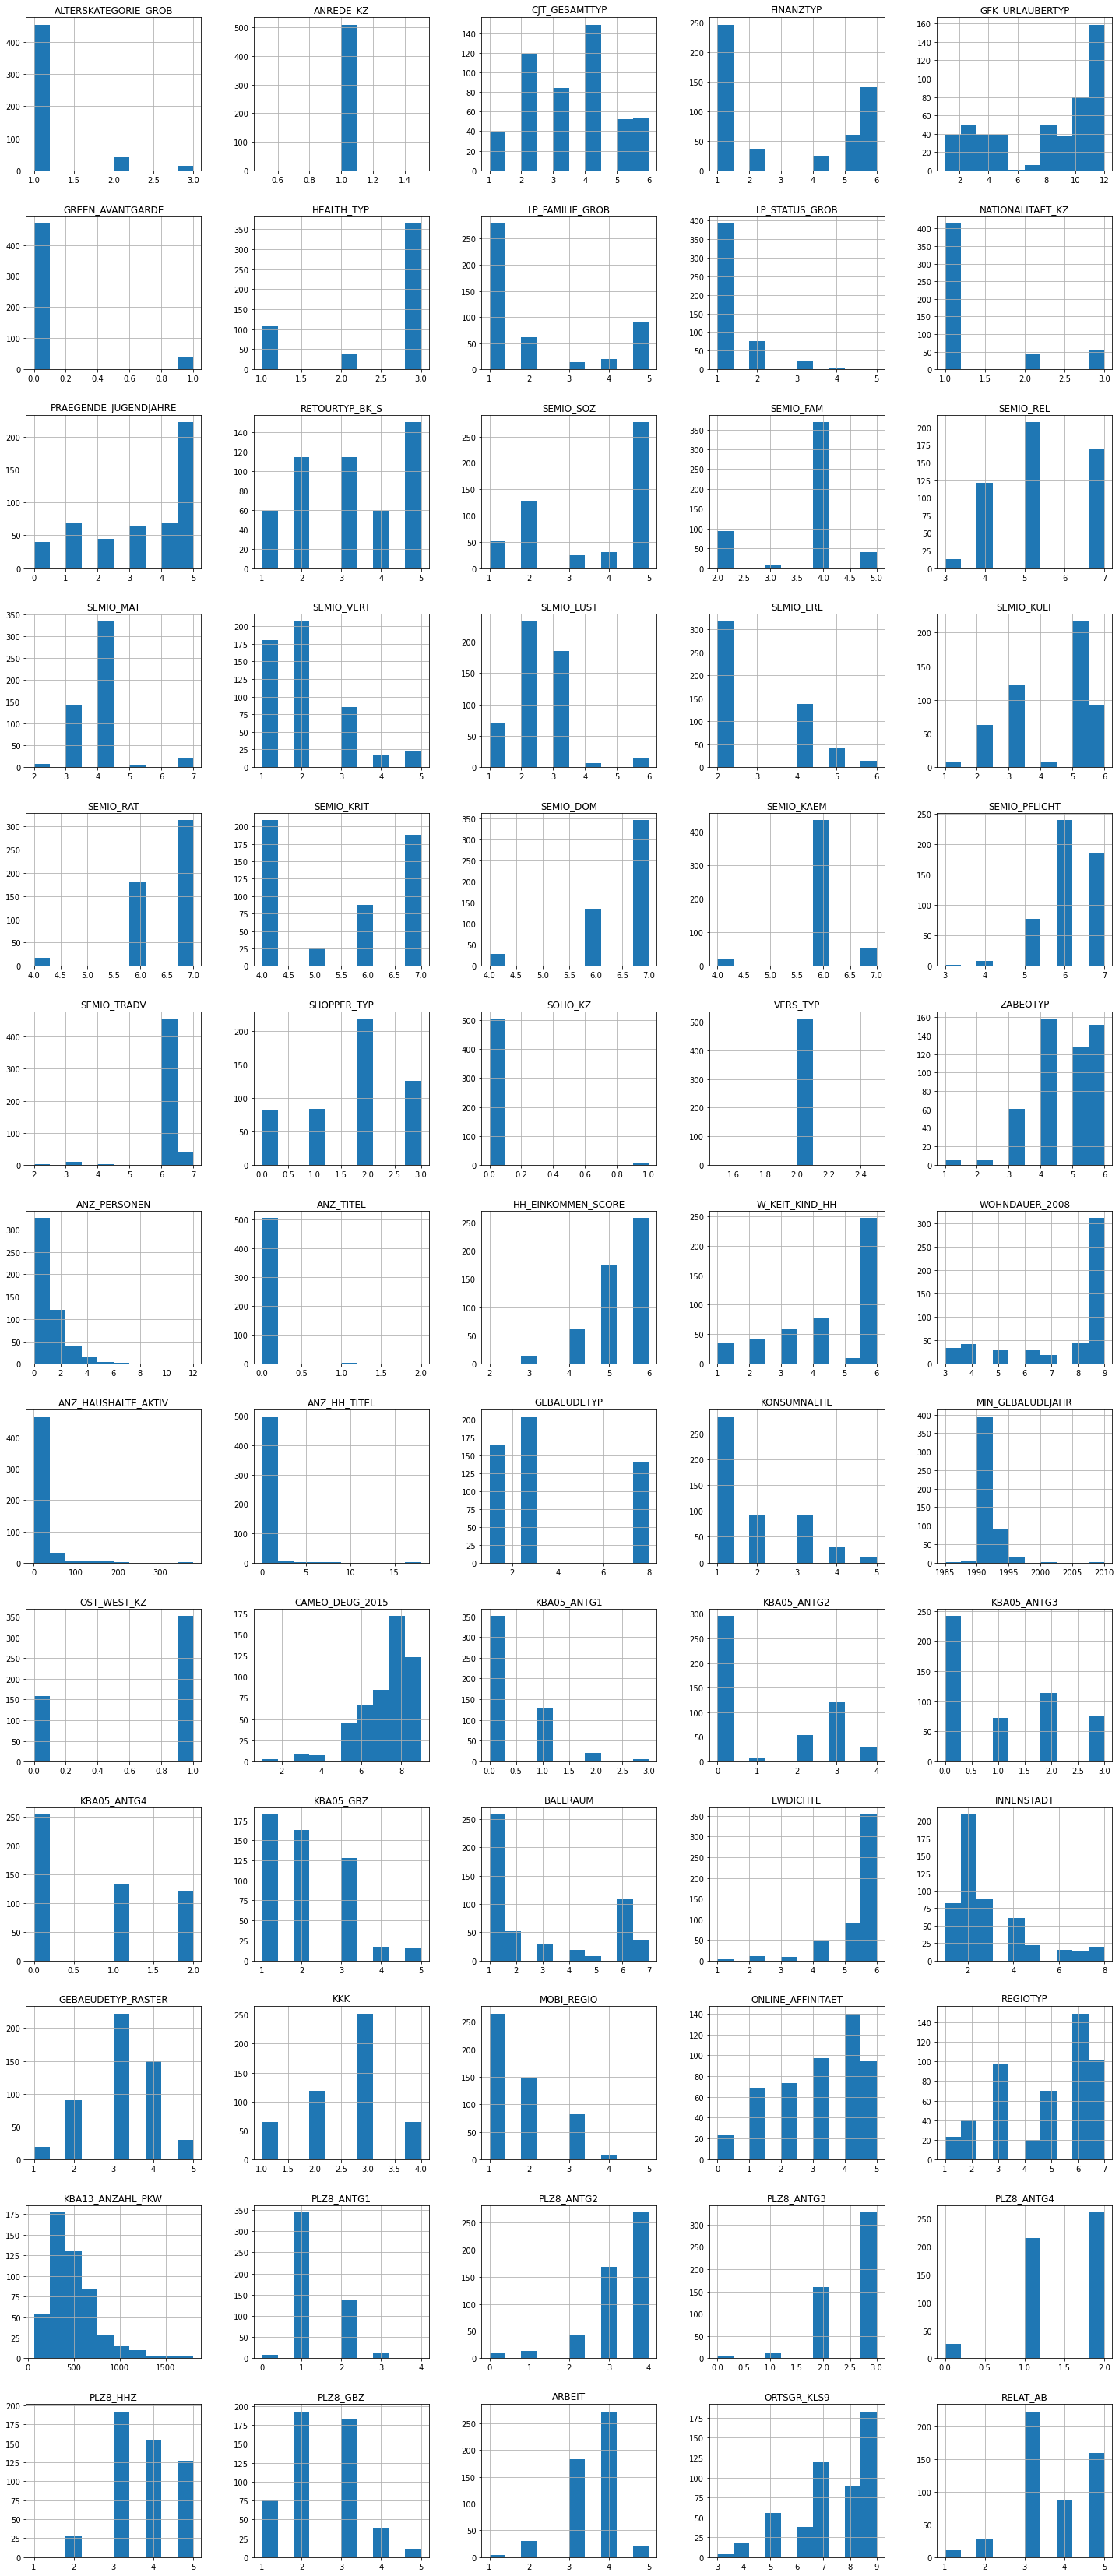

In [57]:
# UNDER REPRESENTED
fig, axes = plt.subplots(len(underrep_cluster.columns)//5, 5, figsize=(25,60))
i = 0
for triaxis in axes:
    for axis in triaxis:
        underrep_cluster.hist(column = underrep_cluster.columns[i], bins = 10, ax=axis)
        i = i+1

**OVER REPRESENTED**

- +60 age men
- advertising and consumption traditionalists
- green avantgarde
- wealthy
- germans
- minimal returners
- religious, rational and combative minded 
- external supplied and demanding shoppers
- social safety driven insurance type
- no profesional or academica titles
- no children households
- 7 to 10 years residence (WOHNDAUER)
- WEST germany
- mostly upper and some middleclass
- 1 to 3 family homes at max in microcell and plz region
- residential or low business share cells
- high purchasing power
- low to very low movement
- +50 km to neares urban center
- low households density
- low or very low unemployment 

**UNDER REPRESENTED**

- young women in their 30s
- mostly Online-shopper
- finance mostly minimalist (low financial interest)
- without vacations
- NOT greenavantgarde
- health jaunty hedonists
- single and low income
- germans
- very dreamful and event oriented minded 
- family shoppers
- insurance individualistic-accepting risks
- price driven energy consumption
- no profesional or academica titles
- no children households
- +10 years residence (WOHNDAUER)
- WEST germany
- working class
- high online affinity
- live near urban center
- high households density
- average purchasing power

### Discussion 3.3: Compare Customer Data to Demographics Data

> We have a pretty even distribution between clusters for the demographic data set while we have some clusters over and under represented in our customer data

> To understand population segments from the demographic dataset and then fit our customers data with that model really makes sense to draw useful conclusions 